In [3]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from sklearn.model_selection import train_test_split,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.feature_extraction.text import  TfidfTransformer,CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import string
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

In [4]:
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, pandas_udf,PandasUDFType
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [5]:
import sys
sys.path.append('/home/013767416/.local/lib/python2.7/site-packages')
!pip3 install --user xgboost

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
# findspark.init('/home/013767416/.local/lib/python2.7/site-packages/pyspark/')

In [3]:
# NLTK libraries for text classification
import nltk
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('crubadan')
# nltk.download('punkt')
# nltk.download('vader_lexicon')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

/opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# Calling spark session to register application
spark = SparkSession \
    .builder \
    .appName("Recom") \
    .config("spark.recom.demo", "1") \
    .getOrCreate()

In [ ]:
# Load data using pyspark
epinion_df_spark = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("../epinion_processed_final.csv")

In [ ]:
epinion_spark_df.head(3)

In [6]:
# Load the preprocessed dataset 
epinion_data = pd.read_csv('../epinion_processed_final.csv')
epinion_data.head(3)

,item,paid,review,stars,time,user,cleaned_review,polarity,sentiment,textblob_polarity,textblob_sentiment
0,pr-Sony_KV_36FS12__Standard_Televisions,1199,well when i graduated from college it didnt ta...,5,1012262400,pyros7,well graduate college didnt take long realize ...,0.8090,5,0.312500,4
1,Minolta_QMS_PagePro_1250E_Printers,260,i got this printer from minolta as a warranty ...,4,1027296000,fgb59h,get printer minolta warranty replacement minol...,-0.0987,3,0.270833,4
2,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,1800,although i love my vaio especially the gorgeou...,2,1201305600,bucho_ky,although love vaio especially gorgeous display...,0.8883,5,0.240000,4


##### Classifying the dataset and splitting it into the reviews and stars:

In [7]:
epinion_class = epinion_data[(epinion_data['sentiment']==1)  | (epinion_data['sentiment']==5 )]
epinion_class.head()
print(epinion_class.shape)

(117576, 11)


#### We will be using 2 things from sklearn:
- A Vectorizer, which transforms our text into number-based representations that are more computer-friendly as computers don't like text, and 
- A Classifier, which is the statistical model that we'll train with our dataset. 
- We will compare the results of two different vectorizers — a simple "Count" vectorizer and a more complicated "TF-IDF" (Term Frequency, Inverse Document Frequency) 

### Feature Engieering using Bag of Words

- Here we are dealing with reviews and their respective rating. 
- But we directly can't use this review for our model. 
- We need to convert the review into vectors of numbers.


- Bag-of-words model(BoW ) : 
   - Bow is the simplest way of extracting features from the text. 
   - BoW will convert review into the matrix of occurrence of words within a review. 
   - This model concerns about whether given words occurred or not in the document.

Example: There are three documents:

Doc 1: I love dogs. 
Doc 2: I hate dogs and knitting. 
Doc 3: Knitting is my hobby and passion.

- We can create a matrix of document and words by counting the occurrence of words in the given document. 
- This matrix is known as Document-Term Matrix(DTM).
- This matrix is using a single word. It can be a combination of two or more words, which is called a bigram or trigram model and the general approach is called the n-gram model.

we can generate document term matrix by using scikit-learn's CountVectorizer.

##### Vectorization of the whole review set

In [8]:

# Seperate the dataset into X and Y for prediction
x = epinion_class['cleaned_review']
y = epinion_class['sentiment']

cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1))
X = cv.fit_transform(x)


##### Split train and test set
- To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

In [9]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=101)

### Now checking different Machine Algorithms to see which gives the best performance.

Building the Text Classification Mode
- Import the MultinomialNB module and create the Multinomial Naive Bayes classifier object using MultinomialNB() function.
- Fit the model on a train set using fit() and perform prediction on the test set using predict().

##### Multinomial Naive Bayes 

- The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
- The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [10]:
mnb_clf = MultinomialNB()
#fit the model
mnb_clf.fit(x_train,y_train)
#predict the output
y_predicted_mnb = mnb_clf.predict(x_test)

In [11]:
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,y_predicted_mnb))
print()
print("Classification Report:")
print(classification_report(y_test,y_predicted_mnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 1567   913]
 [ 1351 19685]]

Classification Report:
             precision    recall  f1-score   support

          1       0.54      0.63      0.58      2480
          5       0.96      0.94      0.95     21036

avg / total       0.91      0.90      0.91     23516



#####  Random Forest Classifier

In [12]:
rf_clf = RandomForestClassifier()
#fit the model
rf_clf.fit(x_train,y_train)
#predict the output
y_predicted_rf = rf_clf.predict(x_test)

In [13]:
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test,y_predicted_rf))
print()
print("Classification Report:")
print(classification_report(y_test,y_predicted_rf))

Confusion Matrix for Random Forest:
[[  751  1729]
 [  199 20837]]

Classification Report:
             precision    recall  f1-score   support

          1       0.79      0.30      0.44      2480
          5       0.92      0.99      0.96     21036

avg / total       0.91      0.92      0.90     23516



##### Decision Tree
- Decision Trees gives us more insight into how the model work.
- We can take a quick look at the rules it produces to find patterns in dataset that we might not have known about.
- https://www.codementor.io/blog/text-classification-6mmol0q8oj

In [14]:
dt_clf = DecisionTreeClassifier()
#fit the model
dt_clf.fit(x_train,y_train)
#predict the output
y_predicted_dt = dt_clf.predict(x_test)  

In [15]:
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,y_predicted_dt))
print()
print("Classification Report:")
print(classification_report(y_test,y_predicted_dt))

Confusion Matrix for Decision Tree:
[[ 1458  1022]
 [  895 20141]]

Classification Report:
             precision    recall  f1-score   support

          1       0.62      0.59      0.60      2480
          5       0.95      0.96      0.95     21036

avg / total       0.92      0.92      0.92     23516



##### Support Vector Machines
- Support Vector Machines are very powerful and can scale to larger data sets
- But they are also more complicated and it can be difficult to know what patterns they rely on.

In [16]:
clf_svc = SVC(random_state=101)
#fit the model
clf_svc.fit(x_train,y_train)
#predict the output
y_predicted_svc = clf_svc.predict(x_test)   

In [17]:
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,y_predicted_svc))
print()
print("Classification Report:")
print(classification_report(y_test,y_predicted_svc))

Confusion Matrix for Support Vector Machines:
[[    0  2480]
 [    0 21036]]

Classification Report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00      2480
          5       0.89      1.00      0.94     21036

avg / total       0.80      0.89      0.84     23516



/opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#####  K Nearest Neighbour

In [18]:
# K Nearest Neighbour Algorithm
clf_knn = KNeighborsClassifier(n_neighbors=10)
#fit the model
clf_knn.fit(x_train,y_train)
#predict the output
y_predicted_knn = clf_knn.predict(x_test)

In [19]:
print("Confusion Matrix for KNN:")
print(confusion_matrix(y_test,y_predicted_knn))
print()
print("Classification Report:")
print(classification_report(y_test,y_predicted_knn))

Confusion Matrix for KNN:
[[  285  2195]
 [  100 20936]]

Classification Report:
             precision    recall  f1-score   support

          1       0.74      0.11      0.20      2480
          5       0.91      1.00      0.95     21036

avg / total       0.89      0.90      0.87     23516



##### Xgboost

In [20]:
xgb_clf = XGBClassifier()
#fit the model
xgb_clf.fit(x_train,y_train)
#predict the output
y_predicted_xgb = xgb_clf.predict(x_test)

/opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
print("Confusion Matrix for KNN:")
print(confusion_matrix(y_test,y_predicted_xgb))
print()
print("Classification Report:")
print(classification_report(y_test,y_predicted_xgb))

Confusion Matrix for KNN:
[[  854  1626]
 [  109 20927]]

Classification Report:
             precision    recall  f1-score   support

          1       0.89      0.34      0.50      2480
          5       0.93      0.99      0.96     21036

avg / total       0.92      0.93      0.91     23516



###### MULTILAYER PERCEPTRON CLASSIFIER

In [22]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier()
#fit the model
mlp_clf.fit(x_train,y_train)
#predict the output
y_predicted_mlp = mlp_clf.predict(x_test)

In [23]:
print("Confusion Matrix for KNN:")
print(confusion_matrix(y_test,y_predicted_mlp))
print()
print("Classification Report:")
print(classification_report(y_test,y_predicted_mlp))

Confusion Matrix for KNN:
[[ 2116   364]
 [  288 20748]]

Classification Report:
             precision    recall  f1-score   support

          1       0.88      0.85      0.87      2480
          5       0.98      0.99      0.98     21036

avg / total       0.97      0.97      0.97     23516



In [24]:
# POSITIVE REVIEW
pr = epinion_data['cleaned_review'][0]
print(pr)
print("Actual Rating: ",epinion_data['stars'][0])
pr_t = vocab.transform([pr])
print("Predicted Rating:")
mnb.predict(pr_t)[0]

# pr = epinion_data['cleaned_review'][995]
# print(pr)
# print("Actual Rating: ",epinion_data['stars'][995])
# pr_t = vocab.transform([pr])
# print("Predicted Rating:")
# xgb.predict(pr_t)[0]


# pr = epinion_data['cleaned_review'][1]
# print(pr)
# print("Actual Rating: ",epinion_data['stars'][1])
# pr_t = vocab.transform([pr])
# print("Predicted Rating:")
# xgb.predict(pr_t)[0]

well graduate college didnt take long realize 15 inch tvvcr combo old dorm room wasnt gonna quite cut real world best buy
Actual Rating:  5


NameError: name 'vocab' is not defined

#### Feature Engineering using TF-IDF:

- In the BoW model which is known as TF, we just count the number of words occurred in each review, we will end up giving more weight to longer length review. 
- IDF(Inverse Document Frequency) measures the amount of information a given word provides across that review. 
- IDF is the logarithmically scaled inverse ratio of the number of review that contain the word and the total number of reviews.
- TF-IDF(Term Frequency-Inverse Document Frequency) normalizes the document term matrix. 
- It is the product of TF and IDF. 
- Word with high tf-idf in a document, it is most of the times occurred in given documents and must be absent in the other documents. So the words must be a signature word.



In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()

# Seperate the dataset into X and Y for prediction
x = epinion_class['cleaned_review']
y = epinion_class['stars']

X = tf.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [30]:

from sklearn.naive_bayes import MultinomialNB
# Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
mn_predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, mn_predicted))

#Random Forest
rf_clf = RandomForestClassifier().fit(X_train, y_train)
rf_predicted= rf_clf.predict(X_test)
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, rf_predicted))

#Decision Tree
dt_clf = RandomForestClassifier().fit(X_train, y_train)
dt_predicted= dt_clf.predict(X_test)
print("Decision Tree Accuracy:",metrics.accuracy_score(y_test, dt_predicted))


#SVM
svm_clf = RandomForestClassifier().fit(X_train, y_train)
svm_predicted= svm_clf.predict(X_test)
print("SVM Accuracy:",metrics.accuracy_score(y_test, svm_predicted))


# K Nearest Neighbour Algorithm
knn_clf = RandomForestClassifier().fit(X_train, y_train)
knn_predicted= knn_clf.predict(X_test)
print("KNN Accuracy:",metrics.accuracy_score(y_test, knn_predicted))

# # XGBoost
# xgb_clf = XGBClassifier()
# #fit the model
# xgb_clf.fit(x_train,y_train)
# #predict the output
# y_predicted_xgb = xgb_clf.predict(x_test)

MultinomialNB Accuracy: 0.454568650242395
Random Forest Accuracy: 0.4723159357015281
Decision Tree Accuracy: 0.4722308848127463
SVM Accuracy: 0.47191903155387976
KNN Accuracy: 0.47407365406968505


XGBoostError: [21:38:32] /workspace/src/objective/multiclass_obj.cu:60: Check failed: preds.Size() == (static_cast<size_t>(param_.num_class) * info.labels_.Size()): SoftmaxMultiClassObj: label size and pred size does not match
Stack trace:
  [bt] (0) /home/013767416/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7fd7f0061cb4]
  [bt] (1) /home/013767416/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(xgboost::obj::SoftmaxMultiClassObj::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x178) [0x7fd7f025af98]
  [bt] (2) /home/013767416/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x345) [0x7fd7f00fb505]
  [bt] (3) /home/013767416/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x35) [0x7fd7f005eaa5]
  [bt] (4) /lib64/libffi.so.6(ffi_call_unix64+0x4c) [0x7fd8b7caadcc]
  [bt] (5) /lib64/libffi.so.6(ffi_call+0x1f5) [0x7fd8b7caa6f5]
  [bt] (6) /opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x69d) [0x7fd8b7ec073d]
  [bt] (7) /opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x9955) [0x7fd8b7eb6955]
  [bt] (8) /opt/ohpc/pub/apps/python3/3.7.0/lib/libpython3.7m.so.1.0(_PyObject_FastCallKeywords+0x97) [0x7fd8c6360077]



##### Comparison of all algorithms on RMSE : Using Count Vectorizer

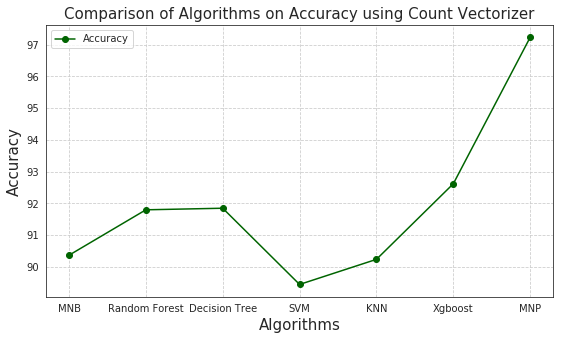

In [27]:
algos = ['MNB', 'Random Forest', 'Decision Tree', 'SVM', 'KNN','Xgboost', 'MNP' ]
y_pred = [y_predicted_mnb, y_predicted_rf, y_predicted_dt, y_predicted_svc, y_predicted_knn, y_predicted_xgb, y_predicted_mlp]

    
accuracy = [round(accuracy_score(y_test,y)*100,2) for y in y_pred]
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on Accuracy using Count Vectorizer', loc='center', fontsize=15)
plt.plot(algos, accuracy, label='Accuracy', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

##### Comparison of all algorithms on RMSE : Using TF-IDF

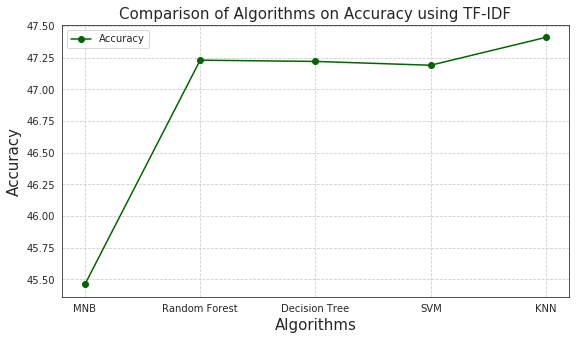

In [31]:
algos = ['MNB', 'Random Forest', 'Decision Tree', 'SVM', 'KNN']
y_pred = [mn_predicted, rf_predicted, dt_predicted, svm_predicted, knn_predicted]

    
accuracy = [round(accuracy_score(y_test,y)*100,2) for y in y_pred]
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on Accuracy using TF-IDF', loc='center', fontsize=15)
plt.plot(algos, accuracy, label='Accuracy', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

##### What we learnt:
- We learnt what Text Analytics is
- NLP and text mining.
- Basics of text analytics operations using NLTK such as Tokenization, Normalization, Stemming, Lemmatization and Part of speeach tagging. 
- What is sentiment analysis and text classification.

https://www.kaggle.com/omkarsabnis/sentiment-analysis-on-the-yelp-reviews-dataset


https://github.com/labdhi-ghelani/Sentiment-analysis-for-Yelp-review-classification/blob/master/Sentiment-analysis-for-Yelp-review-classification.ipynb


https://www.kaggle.com/suzanaiacob/sentiment-analysis-of-the-yelp-reviews-data
